# Packages to Install

In [6]:
#!pip install opencv-python
#!pip install scipy
#!pip install tensorflow-addons
#!pip install pydot    

^C


# All Imports 


In [1]:
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout,Conv2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import Counter


#  Data paths


In [2]:
#data and model paths 
oTrainDataPath = "D:\\PRS_project\\Data_Set_HAM\\center_crop_train_val_final\\train\\"
oValDataPath = "D:\\PRS_project\\Data_Set_HAM\\center_crop_train_val_final\\val\\"
#directory to which the trained checkpoints are saved
oModelPath = "D:\PRS_project\\Model\\center_cropped\\"

# Data Generator

In [3]:
#create training Image Generator
oTrainGen = ImageDataGenerator( samplewise_std_normalization=False,
                               samplewise_center=False,
                               rotation_range=30,zoom_range=0.3,
                               width_shift_range=0,height_shift_range=0,
                               brightness_range = [0.7, 1.3],
                               shear_range=0.0,horizontal_flip=True,
                               vertical_flip=True,fill_mode="nearest",
                              )
#create validation Image Generator
oValGen = ImageDataGenerator( samplewise_std_normalization=False,
                               samplewise_center=False,
                               rotation_range=0,zoom_range=0,
                               width_shift_range=0.0,height_shift_range=0.0,
                               shear_range=0.0,horizontal_flip=False,
                               vertical_flip=False,fill_mode="nearest",
                              )


#read training data batch by batch
oTrainingGenerator = oTrainGen.flow_from_directory(directory=oTrainDataPath,
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   batch_size=16,
                                                   class_mode="binary",
                                                   shuffle=True,
                                                   seed=42
                                                   )
#read validation data batch by batch
oValGenerator = oValGen.flow_from_directory(directory=oValDataPath,
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   batch_size=16,
                                                   class_mode="binary",
                                                   shuffle=True,
                                                   seed=42
                                                   )
counter = Counter(oTrainingGenerator.classes)

print(counter.items())

Found 8111 images belonging to 2 classes.
Found 902 images belonging to 2 classes.
dict_items([(0, 902), (1, 7209)])


# Load Pretrained Model

In [4]:
# create the base pre-trained model
#specify which pretrained model should be loaded 
oFlag = "DenseNet121"
input_tensor = Input(shape=(224, 224, 3),dtype = tf.uint8)

if oFlag ==  "InceptionV3":    
    base_model = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "ResNet50V2":
    base_model = ResNet50V2(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "MobileNetV2":
    x = tf.cast(input_tensor, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)    
    base_model = MobileNetV2(input_tensor=x,weights='imagenet', include_top=False)
elif oFlag ==  "DenseNet121":
    x = tf.cast(input_tensor, tf.float32)
    x = tf.keras.applications.densenet.preprocess_input(x)
    base_model = DenseNet121(input_tensor=x,weights='imagenet', include_top=False)
elif oFlag ==  "EfficientNetB0":
    base_model = EfficientNetB0(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "EfficientNetB3":
    base_model = EfficientNetB3(input_tensor=input_tensor,weights='imagenet', include_top=False)


# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
#add a fully-connected layer and the output layer
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(1, activation='sigmoid')(x)

# create the model
model = Model(inputs=input_tensor, outputs=prediction)

#Add Regularizer to conv and dense layers
alpha = 1e-4
for layer in model.layers:
    if isinstance(layer,Conv2D) or isinstance(layer,Dense):
        layer.add_loss(lambda: regularizers.l2(alpha)(layer.kernel))
    #if hasattr(layer,'bias_regularizer') and layer.use_bias:
    #    layer.add_loss(lambda: regularizers.l2(alpha)(layer.bias))
        

model.summary()

#compile the model
oFocalLoss = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy",metrics = ['accuracy'])#,weighted_metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 224, 224, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.math.truediv[0][0]            
______________________________________________________________________________________________

C:\Users\rggop\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Callbacks

In [5]:
# Create a callback that saves the model's weights
checkpoint_path = os.path.join(oModelPath,oFlag + ".hdf5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor ='val_loss',  
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)
#create callbacks for monitoring training
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

csv_logger      = CSVLogger(os.path.join(oModelPath,oFlag+'.csv'))
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#create callback for reducing learning rate
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, mode = 'min',min_lr=0.000005)

callbacks=[cp_callback,tb_callback,csv_logger,early_stoping]

# Fit Model

In [6]:

print(tf.test.gpu_device_name())

/device:GPU:0


In [6]:

STEP_SIZE_TRAIN=oTrainingGenerator.n//oTrainingGenerator.batch_size
STEP_SIZE_VALID=oValGenerator.n//oValGenerator.batch_size
#class weights 
class_weight = {0:6 ,1:1}
#model.fit_generator(generator=oTrainingGenerator,
#          steps_per_epoch=STEP_SIZE_TRAIN,
#          validation_data=oValGenerator,
#          validation_steps=STEP_SIZE_VALID,
#          callbacks = callbacks,
#          verbose = 1,
#          epochs=150)

model.fit(x=oTrainingGenerator, y=None, batch_size=16, epochs=100, verbose=1,callbacks=callbacks, 
    validation_data=oValGenerator, shuffle=True, steps_per_epoch=STEP_SIZE_TRAIN,class_weight = class_weight,
    validation_steps=STEP_SIZE_VALID, validation_batch_size=16)

Epoch 1/100
506/506 [==============================] - 478s 895ms/step - loss: 1.0001 - accuracy: 0.6374 - val_loss: 0.8656 - val_accuracy: 0.5759

Epoch 00001: val_loss improved from inf to 0.86556, saving model to D:\PRS_project\Model\center_cropped\DenseNet121.hdf5
Epoch 2/100
506/506 [==============================] - 438s 865ms/step - loss: 0.8412 - accuracy: 0.7266 - val_loss: 0.3488 - val_accuracy: 0.8638

Epoch 00002: val_loss improved from 0.86556 to 0.34885, saving model to D:\PRS_project\Model\center_cropped\DenseNet121.hdf5
Epoch 3/100
506/506 [==============================] - 438s 865ms/step - loss: 0.8170 - accuracy: 0.7540 - val_loss: 0.4806 - val_accuracy: 0.7768

Epoch 00003: val_loss did not improve from 0.34885
Epoch 4/100
506/506 [==============================] - 437s 864ms/step - loss: 0.7694 - accuracy: 0.7736 - val_loss: 0.4150 - val_accuracy: 0.8136

Epoch 00004: val_loss did not improve from 0.34885
Epoch 5/100
506/506 [==============================] - 438s 

506/506 [==============================] - 438s 865ms/step - loss: 0.3845 - accuracy: 0.8962 - val_loss: 0.4018 - val_accuracy: 0.8292

Epoch 00040: val_loss did not improve from 0.23183
Epoch 41/100
506/506 [==============================] - 437s 864ms/step - loss: 0.3452 - accuracy: 0.9030 - val_loss: 0.3646 - val_accuracy: 0.8404

Epoch 00041: val_loss did not improve from 0.23183
Epoch 42/100
506/506 [==============================] - 438s 865ms/step - loss: 0.3658 - accuracy: 0.8964 - val_loss: 0.2622 - val_accuracy: 0.8806

Epoch 00042: val_loss did not improve from 0.23183
Epoch 43/100
506/506 [==============================] - 438s 865ms/step - loss: 0.3329 - accuracy: 0.9095 - val_loss: 0.4778 - val_accuracy: 0.8047

Epoch 00043: val_loss did not improve from 0.23183
Epoch 44/100
506/506 [==============================] - 438s 865ms/step - loss: 0.3514 - accuracy: 0.9028 - val_loss: 0.3320 - val_accuracy: 0.8650

Epoch 00044: val_loss did not improve from 0.23183
Epoch 45/100


KeyboardInterrupt: 

# Plot curves on validation loss and accuracy

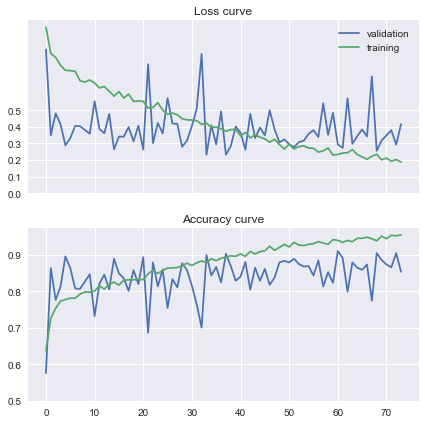

In [5]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= False
plt.rcParams['ytick.left']      = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

records     = pd.read_csv(os.path.join(oModelPath,oFlag +'.csv'))
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.1,0.2,0.3,0.4,0.50])
plt.title('Loss curve',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8,0.9])
plt.title('Accuracy curve',fontsize=12)
ax.legend()
#save the plot
plotpath  = os.path.join(oModelPath,oFlag + '_plot.png')
plt.savefig(plotpath)
#Display
plt.show()

#  Save the model plot


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Path to plot: D:\PRS_project\Model\MobileNetV2_plot.png
